<a href="https://colab.research.google.com/github/Anil1331/EIP3-Assignments/blob/master/Gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!rm -rf tiny-imagenet-200.zip tiny-imagenet-200
!git clone https://github.com/raghakot/keras-resnet.git
!cp drive/'My Drive'/tiny-imagenet-200_flow.zip .
!unzip -qq tiny-imagenet-200_flow.zip
!rm -rf tiny-imagenet-200/val/images tiny-imagenet-200/val/val_annotations.txt
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.

import tensorflow as tf
from keras import backend as k
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Cloning into 'keras-resnet'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 1.65 MiB | 2.03 MiB/s, done.
Resolving deltas: 100% (58/58), done.
     |████████████████████████████████| 993kB 41.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


Using TensorFlow backend.


In [0]:
IMAGE_SIZE, TRAINING_IMAGES_DIR, VAL_IMAGES_DIR = None, None, None
model_file="Imagenetvdbig.hdf5"  
def set_image_size(image_size):
  global IMAGE_SIZE, TRAINING_IMAGES_DIR, VAL_IMAGES_DIR
  IMAGE_SIZE = image_size
  if IMAGE_SIZE == 32:
    TRAINING_IMAGES_DIR = 'tiny-imagenet-200-32/train/'
    VAL_IMAGES_DIR = 'tiny-imagenet-200-32/val/'
  else:
    TRAINING_IMAGES_DIR = 'tiny-imagenet-200/train/'
    VAL_IMAGES_DIR = 'tiny-imagenet-200/val/'
set_image_size(64)  

In [0]:
def drive_authenticate():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive

In [0]:
import shutil
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as k
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, Callback, ModelCheckpoint
from keras.utils import Sequence
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import imgaug as ia
from imgaug import augmenters as iaa
from keras.layers import Concatenate

BATCH_SIZE = 8
NUM_CLASSES = 200
NUM_IMAGES_PER_CLASS = 500
NUM_IMAGES = NUM_CLASSES * NUM_IMAGES_PER_CLASS
TRAIN_SIZE = NUM_IMAGES
NUM_CHANNELS = 3
NUM_VAL_IMAGES = 10000
NUM_EPOCHS = 50
IMAGE_SIZE_T = 64

ia.seed(1)
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.

seq20 = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-10, 10),
            shear=(-4, 4),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 2),
            [
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                ]),
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

seq32 = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-10, 10),
            shear=(-4, 4),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 2),
            [
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),
                iaa.Invert(0.05, per_channel=True), 
                iaa.Add((-10, 10), per_channel=0.5),
                iaa.Multiply((0.5, 1.5), per_channel=0.5),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)


seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.5, 1), "y": (0.5, 1)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-20, 20),
            shear=(-8, 8),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),
                iaa.Invert(0.05, per_channel=True), 
                iaa.Add((-10, 10), per_channel=0.5),
                iaa.Multiply((0.5, 1.5), per_channel=0.5),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

def save_to_drive(drive, epoch, filename):  
  title = 'Imagenetvdbig' + str(epoch) + '.hdf5'
  model_file = drive.CreateFile({'title' : title})
  model_file.SetContentFile(filename)
  model_file.Upload()
  print("Saving to id", model_file.get('id'))
  # download to google drive
  drive.CreateFile({'id': model_file.get('id')})    
  
  
def get_from_drive(idv):
  global model_file
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  last_weight_file = drive.CreateFile({'id': idv}) 
  last_weight_file.GetContentFile(model_file)    
  
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='val_acc', mode='max', value=0.98, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        global model_file
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)
        print("Current learning rate", k.get_value(self.model.optimizer.lr), k.get_value(self.model.optimizer.iterations)) 
        self.model.save(model_file, overwrite=True)
        epoch = int((k.get_value(self.model.optimizer.iterations))/(int(NUM_IMAGES/BATCH_SIZE)))
        #if(epoch%5==0):
        drive = drive_authenticate()
        save_to_drive(drive, epoch, model_file)
        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
            
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True, featurewise_std_normalization=True)
    #preprocessing_function=seq32.augment_image) 
train_datagen.mean = np.array([0.480337294172018, 0.44825522891986064, 0.39783786137898763], dtype=np.float32).reshape((1,1,3))
train_datagen.std = np.array([0.27676311280482857, 0.26885390556775607, 0.28181860401080205], dtype=np.float32).reshape((1,1,3))
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True, featurewise_std_normalization=True,
    shear_range = 0, # random application of shearing
    zoom_range = 0,
    horizontal_flip = False) 
valid_datagen.mean = np.array([0.480337294172018, 0.44825522891986064, 0.39783786137898763], dtype=np.float32).reshape((1,1,3))
valid_datagen.std = np.array([0.27676311280482857, 0.26885390556775607, 0.28181860401080205], dtype=np.float32).reshape((1,1,3))
train_generator = train_datagen.flow_from_directory(
    TRAINING_IMAGES_DIR,
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE_T, IMAGE_SIZE_T),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
    seed=42)
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
val_generator = valid_datagen.flow_from_directory(
    directory=VAL_IMAGES_DIR,
    target_size=(IMAGE_SIZE_T, IMAGE_SIZE_T),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False,
    seed=42
)
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size 

lr_reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                                    cooldown=0, patience=5, min_lr=0.0000001)
model_checkpoint= ModelCheckpoint(model_file, monitor="val_acc", save_best_only=False,
                                  verbose=1)
early_stopping = EarlyStoppingByAccuracy(monitor='val_acc', value=0.70, verbose=1)
csv_logger = CSVLogger('resnet50_imagenet200.csv')           

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [0]:
def bn_relu_conv(block, num_filter, conv_size):
  block = BatchNormalization(epsilon=1.1e-5)(block)
  block = Activation('relu')(block)
  block = SeparableConv2D(num_filter, conv_size, use_bias=False, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(block)  
  return block

def add_denseblock(input, num_filter, out_filter):
  temp = input
  for _ in range(3):        
      block = bn_relu_conv(temp, num_filter, (3, 3))
      concat = Concatenate(axis=-1)([temp,block])
      temp = concat
      out_filter += num_filter

  return temp, out_filter

def add_transition(input, num_filter, pool=False):
  block = bn_relu_conv(input, num_filter, (1, 1))
  if pool:
    block = AveragePooling2D(pool_size=(2,2))(block)    
  return block, num_filter

def output_layer(input):
  block = bn_relu_conv(input, NUM_CLASSES, (1, 1))
  block = BatchNormalization()(block)
  block = Activation('relu')(block)
  block = GlobalAveragePooling2D()(block)
  output = Softmax(NUM_CLASSES)(block)
  return output

In [0]:
import tensorflow as tf
def space_to_depth_2(x):
    return tf.space_to_depth(x, block_size=2)
  
def space_to_depth_4(x):
    return tf.space_to_depth(x, block_size=4)  

In [0]:
def densenet(num_filter=32):
  block = Conv2D(int(num_filter/2), (3,3), use_bias=False ,padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(input)
  block1, out1 = add_denseblock(block, num_filter, num_filter*2)
  block1, out1 = add_transition(block1, out1)
  block2, out2 = add_denseblock(block1, num_filter, out1)
  block2, out2 = add_transition(block2, out2)
  block3, out3 = add_denseblock(block2, num_filter, out2)
  block3, out3 = add_transition(block3, out3, pool=True)
  block4, out4 = add_denseblock(block3, num_filter, out3)
  block4, out4 = add_transition(block4, out4, pool=True)
  c1 = bn_relu_conv(block2, 64, (1,1))
  c1 = Lambda(space_to_depth_4)(c1)
  c2 = bn_relu_conv(block3, 256, (1,1))
  c2 = Lambda(space_to_depth_2)(c2)
  block = Concatenate(axis=-1)([c1,c2,block4])
  block = bn_relu_conv(block, NUM_CLASSES*8, (1,1))
  block = bn_relu_conv(block, NUM_CLASSES*4, (3,3))  
  block = bn_relu_conv(block, NUM_CLASSES*2, (3,3))    
  output = output_layer(block)    
  model = Model(inputs=[input], outputs=[output])
  return model

In [0]:
from keras.layers.advanced_activations import Softmax
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, GlobalAveragePooling2D, SeparableConv2D
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
input = Input(shape=(64, 64, NUM_CHANNELS,))
model = densenet(num_filter=64)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 64, 64, 32)   128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 64, 64, 32)   0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
separable_

In [0]:
from keras.models import load_model
!cp drive/'My Drive'/Imagenetvdbig19.hdf5 .
model = load_model('Imagenetvdbig19.hdf5', custom_objects={"tf": tf})

In [0]:
predict = model.predict_generator(val_generator, steps = STEP_SIZE_VALID)

In [0]:
predicted_labels = [np.argmax(x, axis=-1) for x in predict]
labels = val_generator.classes
indices = [i for i, x in enumerate(predicted_labels) if predicted_labels[i]!=labels[i]]
f = val_generator.filenames
f = [x for i,x in enumerate(f) if i in indices]

In [0]:
class_idx = np.argmax(predict[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.layers[-3]
class_output = model.output[:, class_idx]

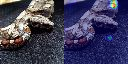

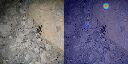

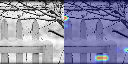

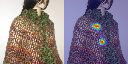

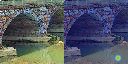

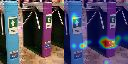

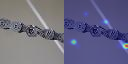

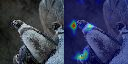

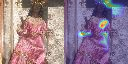

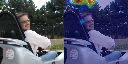

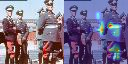

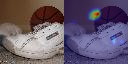

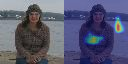

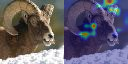

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


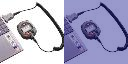

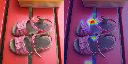

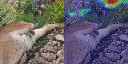

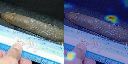

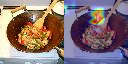

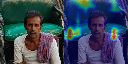

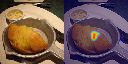

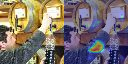

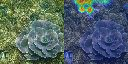

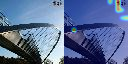

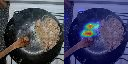

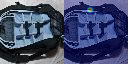

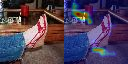

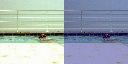

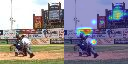

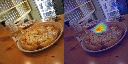

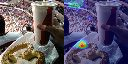

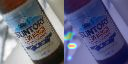

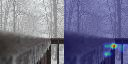

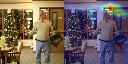

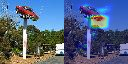

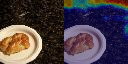

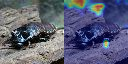

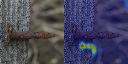

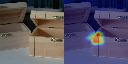

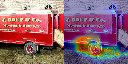

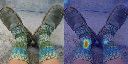

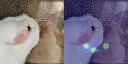

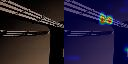

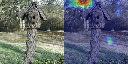

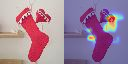

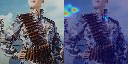

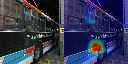

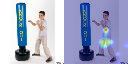

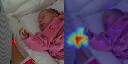

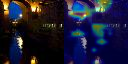

'  \nplt.figure(figsize=(20,10))\ncolumns = 2\nfor i, image in enumerate([cv2.imread(fold+f[i]) for i in range(50)]):\n    plt.subplot(len(images) / columns + 1, columns, i + 1)\n    plt.imshow(image) \n'

In [0]:
import random
index = 5
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
fold = "tiny-imagenet-200/val/"
fault = random.sample([i for i in range(len(f))], 50)
for index in fault: 
  img = np.asarray(Image.open(fold+f[index]))
  img = img.copy()
  img = img/255
  x = [img]
  grads = k.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = k.mean(grads, axis=(0, 1, 2))
  iterate = k.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(200):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = cv2.imread(fold+f[index])
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  concat = np.concatenate((img, superimposed_img), axis=1)
  cv2_imshow(concat)